In [1]:
from torchsat.models.segmentation.unet import UNetResNet

import rasterio as rio
import numpy as np
import os, sys
# add the unet helpers
sys.path.append('../../')
# from test_unet_helpers import *
from utils import variable
from unet_models import unet11_MS

import utils as pyt_utils
from torch.optim import Adam
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from validation import validation_binary
from loss import LossBinary
import json
from torch import nn
import torch
import torch.nn.functional as F

from glob import glob
import time
from sklearn.metrics import roc_auc_score, log_loss, roc_auc_score, roc_curve, auc, f1_score, precision_score, recall_score, precision_recall_fscore_support

In [2]:
def dice_loss(pred,target):
    numerator = 2 * torch.sum(pred * target)
    denominator = torch.sum(pred + target)
    return 1 - (numerator + 1) / (denominator + 1)

# DICE loss https://forums.fast.ai/t/understanding-the-dice-coefficient/5838
def dice_coeff(pred, target):
    smooth = 1.
    num = pred.size(0)
    m1 = pred.view(num, -1)  # Flatten
    m2 = target.view(num, -1)  # Flatten
    intersection = (m1 * m2).sum()

    return (2. * intersection + smooth) / (m1.sum() + m2.sum() + smooth)

class SoftDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(SoftDiceLoss, self).__init__()

    def forward(self, logits, targets):
        probs = F.sigmoid(logits) #investigate
        #probs = torch.relu(torch.sign(logits)) # this goes to zero and 1
        num = targets.size(0)  # Number of batches

        #score = dice_coeff(probs, targets)
        #score = 1 - score.sum() / num
        
        score = dice_loss(probs, targets)
        return score


class DG_GT_Dataset(Dataset):
    """Dataset class DG and GT data"""
    
    def __init__(self, data_dir, channels='all', img_transform=None, gt_transform=None, rot=False):
        """ 
        Args:
            data_dir (string): the folder containing the image files
            channels (string): 'all', 'bgr', 'bgrn1', 'bgrn2'; band sets for DG imagery
            img_transform (callable, optional): Optional transform to  be applied to source image data
            gt_transform (callable, optional): Optional transform to  be applied to labeled image data
            x_var (iterable, optional): list of predictor variable names
            land_mask (string, optional): defines whether or not to return land mask
        """
        
        # some sanity checks
        assert os.path.exists(data_dir)
        
        self.gt_files = sorted(glob(data_dir + '/gt*.tif'))
        self.img_files = sorted(glob(data_dir + '/dg*.tif'))
        
        
        print(self.img_files[0])
        print(self.gt_files[0])
        
        self.img_transform = img_transform
        self.gt_transform = gt_transform
        self.dg_bgr = [1,2,4]
        self.dg_bgrn1 = [1,2,4,6]
        self.dg_bgrn2 = [1,2,4,7]
        self.channels = channels
        self.rot = rot
        
        assert len(self.img_files) == len(self.gt_files)
        
    
    def __getitem__(self, idx):
        
        """
            Files are organized as <var_type>_<year>_<month>_t<tileNumber>.tif, e.g., Arson_1992_1_t1
            A single dataset needs to be constructed for a given ignition type, year, month, and tile number
        """
        
        img_file = self.img_files[idx]
        gt_file = self.gt_files[idx]
        
        with rio.open(img_file) as src:
            img_arr = src.read()
            
        # check the channels
        if self.channels == 'bgr':
            img_arr = img_arr[self.dg_bgr, :, :]
        elif self.channels == 'bgrn1':
            img_arr = img_arr[self.dg_bgrn1, :, :]
        elif self.channels == 'bgrn2':
            img_arr = img_arr[self.dg_brgn2, :, :]
        else:
            pass
            
        with rio.open(gt_file) as src:
            gt_arr = src.read()
            
        #print(img_arr.shape, gt_arr.shape)

        # first consider the rotation argument
        if self.rot:
            dg_t = torch.from_numpy(img_arr)
            gt_t = torch.from_numpy(gt_arr)
            
            # get a random number
            rot_p = np.random.random()*100
            
            # do nothing
            if rot_p < 15:
                
                return (dg_t, gt_t)
            
            elif (rot_p >= 15) and (rot_p < 50):
                
                dg_rot = dg_t.transpose(1,2)
                gt_rot = gt_t.transpose(1,2)
                
                return (dg_rot, gt_t)
            
            elif (rot_p >= 50) and (rot_p < 75):
                
                dg_rot = dg_t.flip(1).flip(2)
                gt_rot = gt_t.flip(1).flip(2)
                
                return (dg_rot, gt_rot)
                
            else:
            
                dg_rot = dg_t.transpose(1,2).flip(2) #t90 CCW
                gt_rot = gt_t.transpose(1,2).flip(2)
                
                return(dg_rot, gt_rot)
            


        if (self.img_transform is not None):
            return (self.img_transform(torch.from_numpy(img_arr)), 
                    self.gt_transform(torch.from_numpy(gt_arr)))   
        else:
            return (torch.from_numpy(img_arr), torch.from_numpy(gt_arr)) # return X, Y, Mask (Mask uses LandMask in X-var folder)
            
        
    def __len__(self):
        return len(self.img_files)

In [3]:
from datetime import datetime

def write_event(log, step: int, **data):
    data['step'] = step
    data['dt'] = datetime.now().isoformat()
    log.write(json.dumps(data, sort_keys=True))
    log.write('\n')
    log.flush()
    
save = lambda ep: torch.save({
        'model': model.state_dict(),
        'epoch': ep,
        'step': step,
    }, str(model_path))

In [4]:


# need to change this to DICE loss!
#loss = LossBinary(jaccard_weight=args.jaccard_weight)
#criterion = nn.CrossEntropyLoss()

torch.manual_seed(0)
np.random.seed(0)
cudnn.benchmark = False
cudnn.deterministic = True

In [5]:
train_folder = r'D:\projects\RD\debug_IS_segmentation\tiles_d10000_256x256\train'
test_folder = r'D:\projects\RD\debug_IS_segmentation\tiles_d10000_256x256\test'
val_folder = r'D:\projects\RD\debug_IS_segmentation\tiles_d10000_256x256\val'

# ubuntu paths
train_folder = '/media/joemcglinchy/Data/projects/RD/debug_IS_segmentation/kmeans3_split/tiles_d10000_256x256/train'
test_folder = '/media/joemcglinchy/Data/projects/RD/debug_IS_segmentation/kmeans3_split/tiles_d10000_256x256/test'
val_folder = '/media/joemcglinchy/Data/projects/RD/debug_IS_segmentation/kmeans3_split/tiles_d10000_256x256/val'

# aws pathts
train_folder = '../../../tiles/kmeans3_split/tiles_d10000_256x256/train'
test_folder = '../../../tiles/kmeans3_split/tiles_d10000_256x256/test'
val_folder = '../../../tiles/kmeans3_split/tiles_d10000_256x256/val'

# load as 4 band
ps_train_ds = DG_GT_Dataset(train_folder, channels='bgrn1')
ps_train_ds_rot = DG_GT_Dataset(train_folder, channels='bgrn1', rot=True)

ps_test_ds = DG_GT_Dataset(test_folder, channels='bgrn1')
ps_val_ds = DG_GT_Dataset(val_folder, channels='bgrn1')

../../../tiles/kmeans3_split/tiles_d10000_256x256/train/dg_is_00000.tif
../../../tiles/kmeans3_split/tiles_d10000_256x256/train/gt_is_00000.tif
../../../tiles/kmeans3_split/tiles_d10000_256x256/train/dg_is_00000.tif
../../../tiles/kmeans3_split/tiles_d10000_256x256/train/gt_is_00000.tif
../../../tiles/kmeans3_split/tiles_d10000_256x256/test/dg_is_00731.tif
../../../tiles/kmeans3_split/tiles_d10000_256x256/test/gt_is_00731.tif
../../../tiles/kmeans3_split/tiles_d10000_256x256/val/dg_is_00500.tif
../../../tiles/kmeans3_split/tiles_d10000_256x256/val/gt_is_00500.tif


In [6]:
# iterate over some batch sizes
times = []
# batch_sizes = [50, 100, 200,300,400,500,600,700,800,900,1000]
# smaller batch sizes as per https://stats.stackexchange.com/questions/164876/tradeoff-batch-size-vs-number-of-iterations-to-train-a-neural-network
#model = unet11_MS(num_bands=4, pretrained=False)

# set some parameters
lr = 0.001
# lr = 0.01
bsize = 32 # was 32

#ps_model = UNet(in_channels=4, n_classes=1, depth=5, wf=6, padding=True, batch_norm=False, up_mode='upconv')
# ps_model = unet11_MS(num_bands=4, pretrained=False)
ps_model = UNetResNet(encoder_depth=152, num_classes=1, in_channels=4, num_filters=32, dropout_2d=0.2,
                 pretrained=False, is_deconv=True)

ps_optimizer = Adam(ps_model.parameters(), lr=lr)
ps_criterion = LossBinary(jaccard_weight=1.0)
# ps_criterion = SoftDiceLoss()

###### specify DataLoaders
n_workers=4 # for some unknown reason, 0 is enabling all GPUs when 4 had previously done the trick. could be slower.
n_workers=torch.cuda.device_count()*2
ps_train_dl = DataLoader(ps_train_ds, batch_size=bsize, shuffle=True, num_workers=n_workers)
ps_train_rot_dl = DataLoader(ps_train_ds_rot, batch_size=bsize, shuffle=True, num_workers=n_workers)
ps_test_dl = DataLoader(ps_test_ds, batch_size=bsize, shuffle=True, num_workers=n_workers)


# make model parallel and on GPU
# device=torch.device("cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # get device for gpu or cpu
if torch.cuda.device_count() >= 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    ps_model = nn.DataParallel(ps_model)
    ps_model.to(device)
else:
    #ps_model = nn.DataParallel(ps_model)
    print('made cpu parallel')

Let's use 4 GPUs!


In [7]:
 torch.cuda.device_count()

4

In [8]:
print('batchsize, ', bsize)
ps_mean_loss = 0.0
ps_running_loss = 0.0
print('training...')

ps_losses=[]
ps_losses_ep = []
ps_step=0

# record time for one epoch
ps_rocs = []
ps_f1 = []
ps_prec = []
ps_recall = []
ps_f1_ep = []
ps_mAP_ep = []
ps_mAR_ep = []

#####################################################

t0 = time.time()
num_epochs = 500
ctr=0
ps_model.train()
for epoch in range(num_epochs):
    
#     try:
    te = time.time()

    epoch_i = epoch+1
    print('on epoch {}'.format(epoch_i))

    running_loss = 0
    
        
    _ps_rocs = []
    _ps_f1 = []
    _ps_prec = []
    _ps_recall = []
    for i, (inputs_, targets_) in enumerate(ps_train_rot_dl):

        #print('hi')

        # get the inputs
        targets_ = targets_.type(torch.FloatTensor)

        #inputs, targets = variable(inputs_).cuda(), variable(targets_).cuda()
        inputs, targets = variable(inputs_), variable(targets_)
        inputs.to(device)
        targets.to(device)

        outputs = ps_model(inputs)

        # zero parameter gradients
        ps_optimizer.zero_grad()

        # forward + backward + optimize            
        i_loss = ps_criterion(outputs, targets)
        i_loss.backward()
        ps_optimizer.step()
        ps_step+=1

        running_loss += i_loss

        #record iterations f1, precision, recall
        _f1 = f1_score(targets.cpu().data.numpy().flatten(), outputs.cpu().data.numpy().squeeze().flatten() > 0., average='binary')
        _ps_f1.append(_f1)
        _prec = precision_score(targets.cpu().data.numpy().flatten(), outputs.cpu().data.numpy().squeeze().flatten() > 0, average='binary')
        _ps_prec.append(_prec)
        _recall = recall_score(targets.cpu().data.numpy().flatten(), outputs.cpu().data.numpy().squeeze().flatten() > 0, average='binary')
        _ps_recall.append(_recall)

        if i%5 == 0: # print/store every 5
            ps_losses.append(i_loss)
            #running_loss += i_loss
            #print('[%d, %5d] loss: %.3f' %(epoch, i + 1, i_loss))

        # debug break
#             ctr+=1
#             if ctr>50:
#                 break

    # append precision and recall metrics
    ps_f1 += _ps_f1
    ps_prec += _ps_prec
    ps_recall += _ps_recall

    ps_f1_ep.append(np.mean(_ps_f1))
    ps_mAP_ep.append(np.mean(_ps_prec))
    ps_mAR_ep.append(np.mean(_ps_recall))

    # get some numbers for the ROC curve
    if epoch_i%2 == 0:
        pred_y = outputs.cpu().data.numpy().squeeze().flatten()
        target_y = targets.cpu().data.numpy().flatten()
        tu = (i_loss, roc_auc_score(target_y,pred_y ))
        print ('epoch: {}, LOSS={}, ROC_AUC={} '.format(epoch_i, *tu))  
        ps_rocs.append(tu[1])


    ps_losses_ep.append(running_loss)
    te1 = time.time()
    print('time for epoch {}: {} seconds'.format(epoch_i, te1-te))

    # early exit critera
#         if len(ps_rocs)>2:
#             if (np.abs(ps_rocs[-1] - ps_rocs[-2]) < 0.009) and (ps_rocs[-1] > 0.98):
#                 print('area under curve not changing significantly, exit loop')
#                 break_flag = False

#                 if break_flag:
#                     break

#     except Exception as e:
#         print('something happened')
#         print(e)
#         break
    

        
t1 = time.time()
print ('total time: ',t1 - t0)
times.append(t1-t0)

batchsize,  32
training...
on epoch 1


/home/ubuntu/anaconda3/envs/spatial_torch2/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


time for epoch 1: 39.51502013206482 seconds
on epoch 2
epoch: 2, LOSS=1.3508048057556152, ROC_AUC=0.643884046549634 
time for epoch 2: 29.65072536468506 seconds
on epoch 3
time for epoch 3: 29.109638690948486 seconds
on epoch 4
epoch: 4, LOSS=1.3028761148452759, ROC_AUC=0.6955677492770521 
time for epoch 4: 30.435173273086548 seconds
on epoch 5
time for epoch 5: 29.656739234924316 seconds
on epoch 6
epoch: 6, LOSS=1.3780319690704346, ROC_AUC=0.6953593788181396 
time for epoch 6: 30.304615020751953 seconds
on epoch 7
time for epoch 7: 29.542537212371826 seconds
on epoch 8
epoch: 8, LOSS=1.1113320589065552, ROC_AUC=0.7409320492479349 
time for epoch 8: 30.023954153060913 seconds
on epoch 9
time for epoch 9: 29.606006860733032 seconds
on epoch 10
epoch: 10, LOSS=1.1638391017913818, ROC_AUC=0.7451044661162172 
time for epoch 10: 30.62954330444336 seconds
on epoch 11
time for epoch 11: 30.511566162109375 seconds
on epoch 12
epoch: 12, LOSS=1.08292818069458, ROC_AUC=0.7510476902154943 
time 

time for epoch 93: 31.215121507644653 seconds
on epoch 94
epoch: 94, LOSS=0.7604946494102478, ROC_AUC=0.8919550850744782 
time for epoch 94: 31.44248914718628 seconds
on epoch 95
time for epoch 95: 31.19751739501953 seconds
on epoch 96
epoch: 96, LOSS=0.9102789759635925, ROC_AUC=0.8713894707482094 
time for epoch 96: 31.540034294128418 seconds
on epoch 97
time for epoch 97: 31.27958083152771 seconds
on epoch 98
epoch: 98, LOSS=0.8286607265472412, ROC_AUC=0.8821491982378107 
time for epoch 98: 31.70782971382141 seconds
on epoch 99
time for epoch 99: 31.181519508361816 seconds
on epoch 100
epoch: 100, LOSS=0.6902433633804321, ROC_AUC=0.9012898928097564 
time for epoch 100: 31.50423836708069 seconds
on epoch 101
time for epoch 101: 30.781152963638306 seconds
on epoch 102
epoch: 102, LOSS=0.7845624089241028, ROC_AUC=0.8859441787998239 
time for epoch 102: 31.54214119911194 seconds
on epoch 103
time for epoch 103: 31.281388521194458 seconds
on epoch 104
epoch: 104, LOSS=0.8135582208633423, 

time for epoch 183: 32.01678729057312 seconds
on epoch 184
epoch: 184, LOSS=0.608178973197937, ROC_AUC=0.934602515177745 
time for epoch 184: 32.39213037490845 seconds
on epoch 185
time for epoch 185: 31.814252614974976 seconds
on epoch 186
epoch: 186, LOSS=0.6118266582489014, ROC_AUC=0.9377207299068727 
time for epoch 186: 32.41981506347656 seconds
on epoch 187
time for epoch 187: 31.695995569229126 seconds
on epoch 188
epoch: 188, LOSS=0.6820636987686157, ROC_AUC=0.9221531105597409 
time for epoch 188: 31.95132803916931 seconds
on epoch 189
time for epoch 189: 31.66390824317932 seconds
on epoch 190
epoch: 190, LOSS=0.6838661432266235, ROC_AUC=0.9229153499146973 
time for epoch 190: 32.032618045806885 seconds
on epoch 191
time for epoch 191: 31.481629848480225 seconds
on epoch 192
epoch: 192, LOSS=0.6541073322296143, ROC_AUC=0.9312327567851848 
time for epoch 192: 32.39846110343933 seconds
on epoch 193
time for epoch 193: 31.801812887191772 seconds
on epoch 194
epoch: 194, LOSS=0.5569

time for epoch 273: 32.65219044685364 seconds
on epoch 274
epoch: 274, LOSS=0.6161640286445618, ROC_AUC=0.9410780884997347 
time for epoch 274: 32.69854784011841 seconds
on epoch 275
time for epoch 275: 32.340697288513184 seconds
on epoch 276
epoch: 276, LOSS=0.551678478717804, ROC_AUC=0.947835944841901 
time for epoch 276: 32.85232901573181 seconds
on epoch 277
time for epoch 277: 32.18445181846619 seconds
on epoch 278
epoch: 278, LOSS=0.544693112373352, ROC_AUC=0.9476544388765529 
time for epoch 278: 32.874218463897705 seconds
on epoch 279
time for epoch 279: 32.526785135269165 seconds
on epoch 280
epoch: 280, LOSS=0.5196409225463867, ROC_AUC=0.9518052589647074 
time for epoch 280: 32.86470937728882 seconds
on epoch 281
time for epoch 281: 32.72012782096863 seconds
on epoch 282
epoch: 282, LOSS=0.537649393081665, ROC_AUC=0.9502160451759211 
time for epoch 282: 32.803895235061646 seconds
on epoch 283
time for epoch 283: 32.627362966537476 seconds
on epoch 284
epoch: 284, LOSS=0.441751

time for epoch 363: 32.91199350357056 seconds
on epoch 364
epoch: 364, LOSS=0.4956008195877075, ROC_AUC=0.9578852634181695 
time for epoch 364: 33.15756011009216 seconds
on epoch 365
time for epoch 365: 33.328479290008545 seconds
on epoch 366
epoch: 366, LOSS=0.41902148723602295, ROC_AUC=0.9672869805312958 
time for epoch 366: 33.21165633201599 seconds
on epoch 367
time for epoch 367: 32.86303162574768 seconds
on epoch 368
epoch: 368, LOSS=0.4808822572231293, ROC_AUC=0.960883644667347 
time for epoch 368: 33.4556450843811 seconds
on epoch 369
time for epoch 369: 33.071462869644165 seconds
on epoch 370
epoch: 370, LOSS=0.47739315032958984, ROC_AUC=0.9590327700604476 
time for epoch 370: 33.16460180282593 seconds
on epoch 371
time for epoch 371: 32.90223145484924 seconds
on epoch 372
epoch: 372, LOSS=0.48741135001182556, ROC_AUC=0.9607438390346525 
time for epoch 372: 33.59892177581787 seconds
on epoch 373
time for epoch 373: 32.969685554504395 seconds
on epoch 374
epoch: 374, LOSS=0.444

time for epoch 453: 33.2494261264801 seconds
on epoch 454
epoch: 454, LOSS=0.3927266299724579, ROC_AUC=0.9701217061835158 
time for epoch 454: 34.050512075424194 seconds
on epoch 455
time for epoch 455: 33.4590528011322 seconds
on epoch 456
epoch: 456, LOSS=0.38601699471473694, ROC_AUC=0.9715656034994292 
time for epoch 456: 34.076141119003296 seconds
on epoch 457
time for epoch 457: 33.793739318847656 seconds
on epoch 458
epoch: 458, LOSS=0.4891228973865509, ROC_AUC=0.9615230525762679 
time for epoch 458: 34.01360726356506 seconds
on epoch 459
time for epoch 459: 33.460522413253784 seconds
on epoch 460
epoch: 460, LOSS=0.4747481942176819, ROC_AUC=0.960298172449381 
time for epoch 460: 33.657668113708496 seconds
on epoch 461
time for epoch 461: 33.62906312942505 seconds
on epoch 462
epoch: 462, LOSS=0.48828041553497314, ROC_AUC=0.9574583035776042 
time for epoch 462: 34.00111675262451 seconds
on epoch 463
time for epoch 463: 34.017802238464355 seconds
on epoch 464
epoch: 464, LOSS=0.42

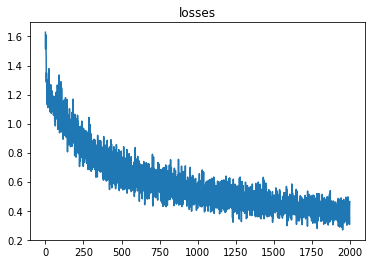

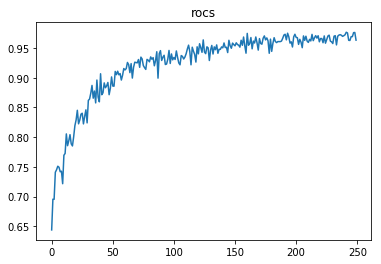

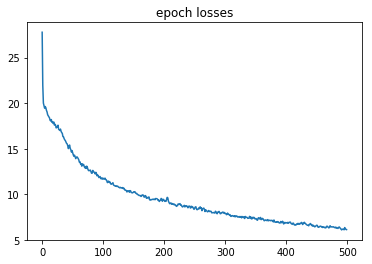

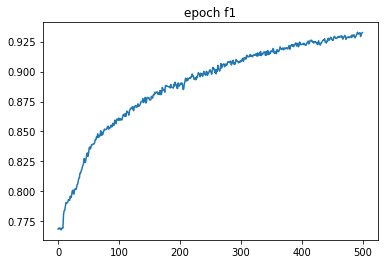

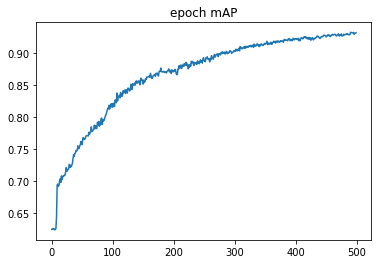

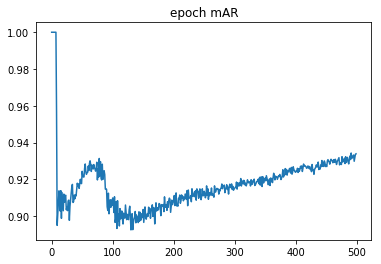

In [13]:
from matplotlib import pyplot as plt

plt.plot(ps_losses)
plt.title('losses')
plt.show()

plt.plot(ps_rocs)
plt.title('rocs')
plt.show()

plt.plot(ps_losses_ep)
plt.title('epoch losses')
plt.show()

plt.plot(ps_f1_ep)
plt.title('epoch f1')
plt.show()

plt.plot(ps_mAP_ep)
plt.title('epoch mAP')
plt.show()

plt.plot(ps_mAR_ep)
plt.title('epoch mAR')
plt.show()

In [14]:
save_res = True

if save_res:
    # directory
    save_dir = 'files_MS_aug_bgrn1'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # save the model
    model_path = 'jstars_bgrn1_ms_aug_ep{}_step{}_b{}.pt'.format(num_epochs, ps_step, bsize)
    model_path = os.path.join(save_dir, model_path)
    save = lambda ep: torch.save({
            'model': ps_model.state_dict(),
            'epoch': ep,
            'step': ps_step,
        }, str(model_path))

    save(model_path)

    # save the AUCs
    auc_path = 'auc_bgrn1_ms_aug_ep{}_step{}_b{}.txt'.format(num_epochs, ps_step, bsize)
    auc_path = os.path.join(save_dir, auc_path)
    np.savetxt(auc_path, np.array(ps_rocs))

    #save the loss vectors
    ep_loss_path = 'losses_ep_bgrn1_ms_aug_ep{}_step{}_b{}.txt'.format(num_epochs, ps_step, bsize)
    ep_loss_path = os.path.join(save_dir, ep_loss_path)
    np.savetxt(ep_loss_path, np.array(ps_losses_ep))

    #save the total loss vector
    loss_path = 'loss_bgrn1_ms_aug_ep{}_step{}_b{}.txt'.format(num_epochs, ps_step, bsize)
    loss_path = os.path.join(save_dir, loss_path)
    np.savetxt(loss_path, np.array(ps_losses))
    
    # save the f1's
    f1_path = 'f1_bgrn1_ms_aug_ep{}_step{}_b{}.txt'.format(num_epochs, ps_step, bsize)
    f1_path = os.path.join(save_dir, f1_path)
    np.savetxt(loss_path, np.array(ps_f1_ep))
    
    # save the f1's
    f1_path = 'f1_bgrn1_ms_aug_ep{}_step{}_b{}.txt'.format(num_epochs, ps_step, bsize)
    f1_path = os.path.join(save_dir, f1_path)
    np.savetxt(f1_path, np.array(ps_f1_ep))
    
    # save the mAPs
    mAP_path = 'mAP_bgrn1_ms_aug_ep{}_step{}_b{}.txt'.format(num_epochs, ps_step, bsize)
    mAP_path = os.path.join(save_dir, mAP_path)
    np.savetxt(mAP_path, np.array(ps_mAP_ep))
    
    # save the mARs
    mAR_path = 'mAR_bgrn1_ms_aug_ep{}_step{}_b{}.txt'.format(num_epochs, ps_step, bsize)
    mAR_path = os.path.join(save_dir, mAR_path)
    np.savetxt(mAR_path, np.array(ps_mAR_ep))
  

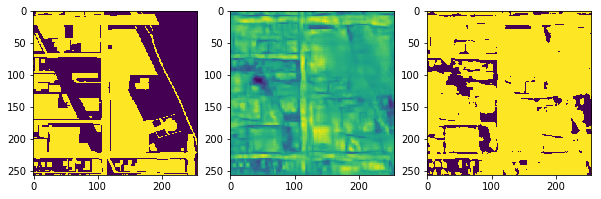

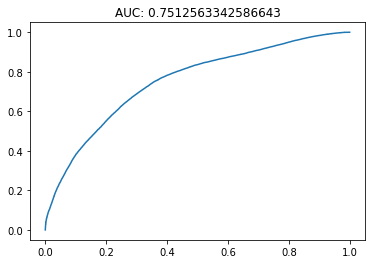

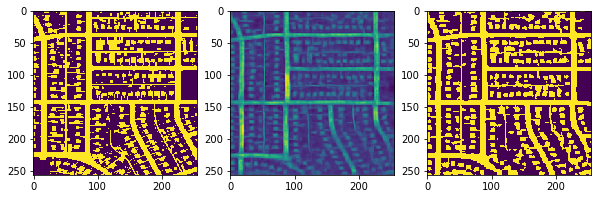

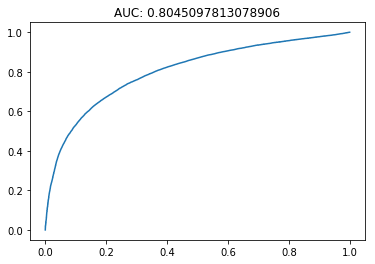

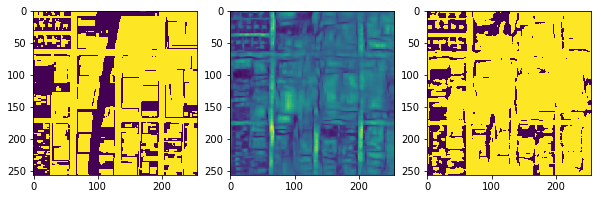

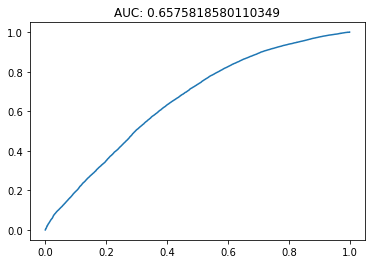

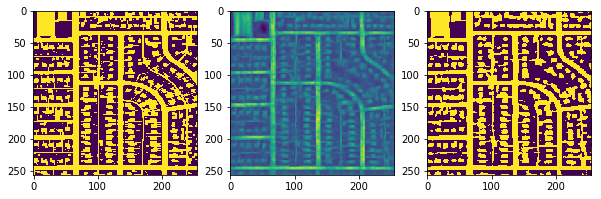

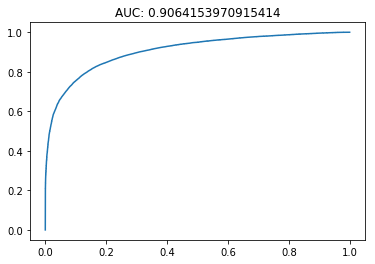

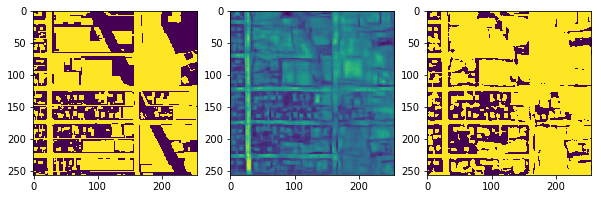

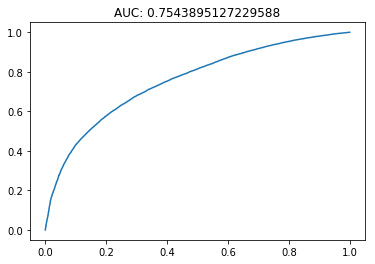

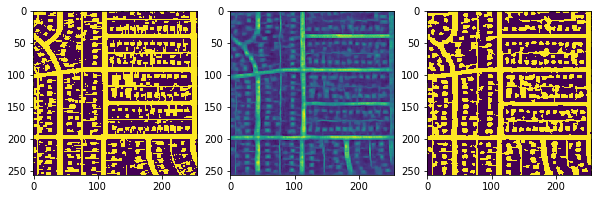

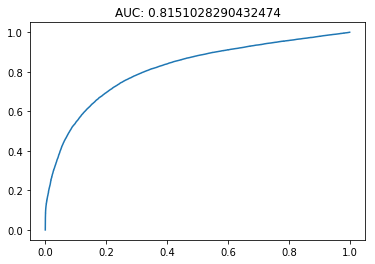

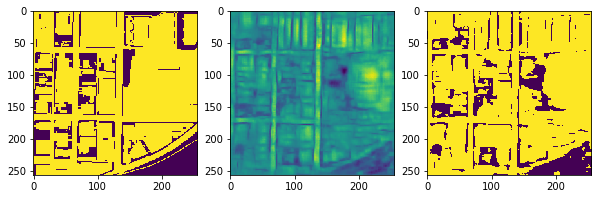

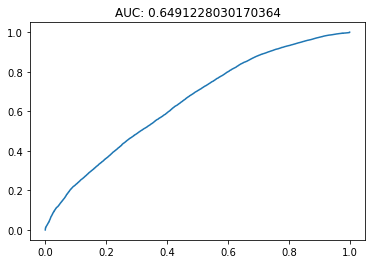

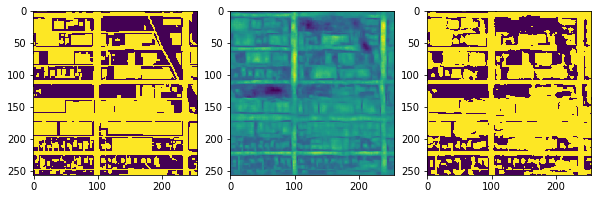

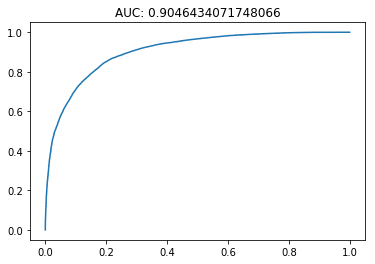

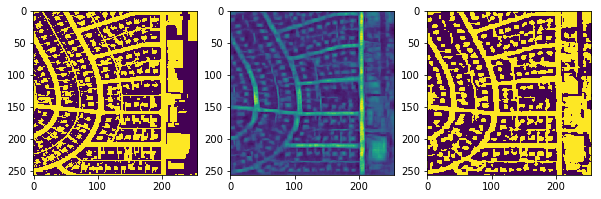

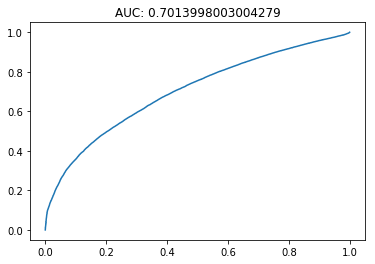

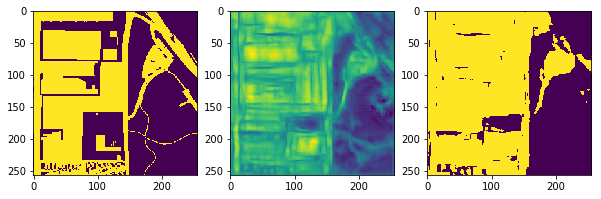

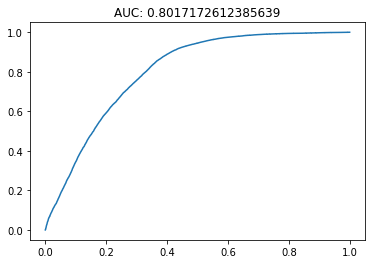

In [11]:
ps_model.eval()
for ind in range(0,10):
    fig, ax = plt.subplots(1,3, figsize=(10,5))
    test_im, test_target = ps_test_ds[ind]
    test_out = ps_model(variable(test_im.unsqueeze(0)))
    ax[0].imshow(test_target.numpy()[0])

    out = test_out.cpu().detach().numpy()[0][0]
    ax[1].imshow(out)

    ax[2].imshow(out>0)
    #ax[2].imshow(test_im.unsqueeze(0).cpu().detach().numpy()[0][0])
    plt.show()
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(test_target.numpy().flatten(), out.flatten())
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate)
    plt.title('AUC: {}'.format(roc_auc))